In [9]:
import csv
from pathlib import Path

from sklearn.metrics import cohen_kappa_score

FIELD_NAMES = ['Pattern', 'Sub Pattern']
COLUMN_MAP = {
    'Pattern': {'Huiyun': 'Huiyun_Pattern', 'Ricardo': 'Ricardo_Pattern'},
    'Sub Pattern': {'Huiyun': 'Huiyun_Sub_Pattern', 'Ricardo': 'Ricardo_Sub_Pattern'},
}
DATASETS = [
    {
        'label': 'final human labels',
        'file': Path('./Final_Human_PRs.csv'),
    },
    {
        'label': 'final agent labels',
        'file': Path('./Final_Agent_PRs.csv'),
    },
]


def load_table(path):
    with path.open(newline='', encoding='utf-8') as f:
        return {row['PR ID']: row for row in csv.DictReader(f)}


def collect_labels(table, field):
    labels_h, labels_r = [], []
    columns = COLUMN_MAP[field]
    for row in table.values():
        a = row.get(columns['Huiyun'], '').strip()
        b = row.get(columns['Ricardo'], '').strip()
        if a and b:
            labels_h.append(a)
            labels_r.append(b)
    return labels_h, labels_r


def compute_metrics(table, field):
    labels_h, labels_r = collect_labels(table, field)
    total = len(labels_h)
    if not total:
        return 0, 0.0, float('nan')
    matches = sum(1 for a, b in zip(labels_h, labels_r) if a == b)
    match_rate = matches / total
    kappa = cohen_kappa_score(labels_h, labels_r)
    return total, match_rate, kappa


for dataset in DATASETS:
    print(f"Cohen's Kappa Agreement (Huiyun vs Ricardo {dataset['label']})")
    print("Identifier columns used: ['PR ID']")
    table = load_table(dataset['file'])
    for field in FIELD_NAMES:
        total, match_rate, kappa = compute_metrics(table, field)
        print(f"Rows compared: {total}")
        field_name = field.lower().replace(' ', '_')
        print(f"  {field_name}: kappa={kappa:.4f}, match_rate={match_rate * 100:.2f}%")


Cohen's Kappa Agreement (Huiyun vs Ricardo final human labels)
Identifier columns used: ['PR ID']
Rows compared: 40
  pattern: kappa=0.6581, match_rate=70.00%
Rows compared: 26
  sub_pattern: kappa=0.5759, match_rate=61.54%
Cohen's Kappa Agreement (Huiyun vs Ricardo final agent labels)
Identifier columns used: ['PR ID']
Rows compared: 155
  pattern: kappa=0.6010, match_rate=65.81%
Rows compared: 101
  sub_pattern: kappa=0.5988, match_rate=62.38%


In [11]:
import csv
from pathlib import Path

csv.field_size_limit(1_000_000_000)

ROUND3_ROOT = Path('../llm_data/new_catalog_round_3')
DATASETS = [
    {
        'name': 'human',
        'gpt': ROUND3_ROOT / 'human_data/human_perf_prs_with_gpt_analysis_new_full_catalog.csv',
        'gemini': ROUND3_ROOT / 'human_data/human_perf_prs_with_gemini_analysis_new_full_catalog.csv',
        'manual': Path('./Final_Human_PRs.csv'),
        'output': Path('./Round3_Final_Human_PRs.csv'),
    },
    {
        'name': 'agent',
        'gpt': ROUND3_ROOT / 'agent_data/ai_perf_prs_with_gpt_analysis_new_full_catalog.csv',
        'gemini': ROUND3_ROOT / 'agent_data/ai_perf_prs_with_gemini_analysis_new_full_catalog.csv',
        'manual': Path('./Final_Agent_PRs.csv'),
        'output': Path('./Round3_Final_Agent_PRs.csv'),
    },
]


def normalize(value: str) -> str:
    return value.strip() if value else ''


def load_llm_rows(path: Path) -> dict:
    rows = {}
    with path.open(newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            pr_id = row['id'].strip()
            rows[pr_id] = {
                'url': row.get('html_url', '').strip(),
                'pattern': normalize(row.get('optimization_pattern', '')),
                'subpattern': normalize(row.get('optimization_subpattern', '')),
            }
    return rows


def load_manual_rows(path: Path) -> dict:
    rows = {}
    with path.open(newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            pr_id = row['PR ID'].strip()
            rows[pr_id] = {
                'url': row.get('PR URL', '').strip(),
                'pattern': normalize(row.get('Final_Pattern', '')),
                'subpattern': normalize(row.get('Final_Sub_Pattern', '')),
            }
    return rows


def write_output(path: Path, rows: list):
    path.parent.mkdir(parents=True, exist_ok=True)
    fieldnames = ['PR ID', 'PR URL', 'Final Pattern', 'Final Sub Pattern', 'Label Source']
    with path.open('w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)


final_label_tables = {}
final_label_stats = {}

for cfg in DATASETS:
    gpt_rows = load_llm_rows(cfg['gpt'])
    gemini_rows = load_llm_rows(cfg['gemini'])
    manual_rows = load_manual_rows(cfg['manual'])

    combined = []
    stats = {'llm_agreement': 0, 'manual_override': 0, 'fallback': 0}
    seen = set()

    for pr_id, gpt_row in gpt_rows.items():
        gemini_row = gemini_rows.get(pr_id, {})
        if (
            gpt_row['pattern'] == gemini_row.get('pattern', '')
            and gpt_row['subpattern'] == gemini_row.get('subpattern', '')
        ):
            combined.append({
                'PR ID': pr_id,
                'PR URL': gpt_row['url'] or gemini_row.get('url', ''),
                'Final Pattern': gpt_row['pattern'],
                'Final Sub Pattern': gpt_row['subpattern'],
                'Label Source': 'llm_agreement',
            })
            stats['llm_agreement'] += 1
        elif pr_id in manual_rows:
            manual_row = manual_rows[pr_id]
            combined.append({
                'PR ID': pr_id,
                'PR URL': manual_row['url'] or gpt_row['url'] or gemini_row.get('url', ''),
                'Final Pattern': manual_row['pattern'],
                'Final Sub Pattern': manual_row['subpattern'],
                'Label Source': 'manual_review',
            })
            stats['manual_override'] += 1
        else:
            combined.append({
                'PR ID': pr_id,
                'PR URL': gpt_row['url'] or gemini_row.get('url', ''),
                'Final Pattern': gpt_row['pattern'],
                'Final Sub Pattern': gpt_row['subpattern'],
                'Label Source': 'llm_fallback',
            })
            stats['fallback'] += 1
        seen.add(pr_id)

    for pr_id, manual_row in manual_rows.items():
        if pr_id not in seen:
            combined.append({
                'PR ID': pr_id,
                'PR URL': manual_row['url'],
                'Final Pattern': manual_row['pattern'],
                'Final Sub Pattern': manual_row['subpattern'],
                'Label Source': 'manual_only',
            })
            stats['manual_override'] += 1
            seen.add(pr_id)

    combined.sort(key=lambda row: row['PR ID'])
    write_output(cfg['output'], combined)
    final_label_tables[cfg['name']] = combined
    final_label_stats[cfg['name']] = stats
    print(
        f"{cfg['name'].title()} final labels: {len(combined)} PRs "
        f"(LLM agreement: {stats['llm_agreement']}, manual: {stats['manual_override']}, "
        f"fallback: {stats['fallback']}). Saved to {cfg['output'].name}."
    )

for name, rows in final_label_tables.items():
    print(f"{name.title()} sample rows:")
    for row in rows[:3]:
        print(row)


Human final labels: 83 PRs (LLM agreement: 43, manual: 40, fallback: 0). Saved to Round3_Final_Human_PRs.csv.
Agent final labels: 324 PRs (LLM agreement: 169, manual: 155, fallback: 0). Saved to Round3_Final_Agent_PRs.csv.
Human sample rows:
{'PR ID': '2260441374', 'PR URL': 'https://github.com/OpenHFT/Chronicle-Core/pull/684', 'Final Pattern': 'Control-Flow and Branching Optimizations', 'Final Sub Pattern': 'Rearranging for early return', 'Label Source': 'manual_review'}
{'PR ID': '2260678480', 'PR URL': 'https://github.com/OpenHFT/Chronicle-Wire/pull/984', 'Final Pattern': 'I/O and Synchronization', 'Final Sub Pattern': 'Concurrency Control / Lock Optimization', 'Label Source': 'llm_agreement'}
{'PR ID': '2269202548', 'PR URL': 'https://github.com/seasonedcc/remix-forms/pull/272', 'Final Pattern': 'Code Smells and Structural Simplification', 'Final Sub Pattern': 'Remove Unnecessary Method Calls', 'Label Source': 'manual_review'}
Agent sample rows:
{'PR ID': '2766896431', 'PR URL': 'h

Combined disagreement cases with manual labels: 195
Combined alignment rates (all disagreement cases)
GPT pattern alignment: 70/195 (35.90%)
GPT subpattern alignment: 35/195 (17.95%)
GEMINI pattern alignment: 74/195 (37.95%)
GEMINI subpattern alignment: 43/195 (22.05%)


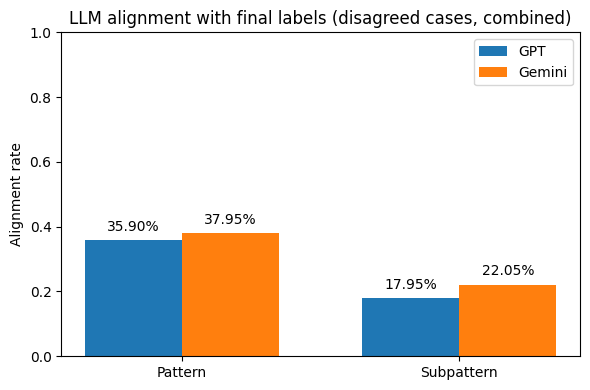


Disagreement cases excluding manual label = No Meaningful Change or Not Performance PR: 145
Alignment rates excluding No Meaningful Change (disagreement cases)
GPT pattern alignment: 70/145 (48.28%)
GPT subpattern alignment: 35/145 (24.14%)
GEMINI pattern alignment: 74/145 (51.03%)
GEMINI subpattern alignment: 43/145 (29.66%)


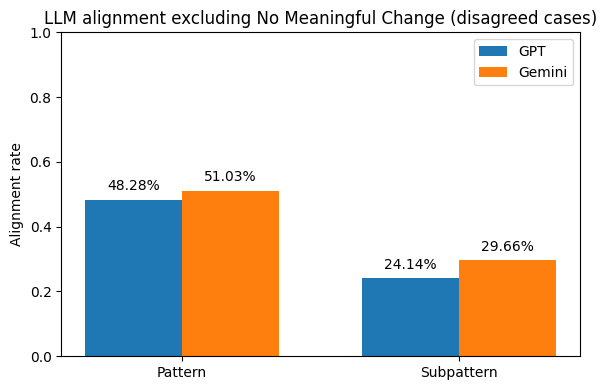

In [9]:
import csv
from pathlib import Path

import matplotlib.pyplot as plt

csv.field_size_limit(1_000_000_000)

ROUND3_ROOT = Path('../llm_data/new_catalog_round_3')
DATASETS = [
    {
        'name': 'human',
        'gpt': ROUND3_ROOT / 'human_data/human_perf_prs_with_gpt_analysis_new_full_catalog.csv',
        'gemini': ROUND3_ROOT / 'human_data/human_perf_prs_with_gemini_analysis_new_full_catalog.csv',
        'manual': Path('./Final_Human_PRs.csv'),
    },
    {
        'name': 'agent',
        'gpt': ROUND3_ROOT / 'agent_data/ai_perf_prs_with_gpt_analysis_new_full_catalog.csv',
        'gemini': ROUND3_ROOT / 'agent_data/ai_perf_prs_with_gemini_analysis_new_full_catalog.csv',
        'manual': Path('./Final_Agent_PRs.csv'),
    },
]

NO_MEANINGFUL_LABEL = 'No Meaningful Change or Not Performance PR'


def normalize(value: str) -> str:
    return value.strip() if value else ""


def load_llm_rows(path: Path) -> dict:
    rows = {}
    with path.open(newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            pr_id = row["id"].strip()
            rows[pr_id] = {
                "pattern": normalize(row.get("optimization_pattern", "")),
                "subpattern": normalize(row.get("optimization_subpattern", "")),
            }
    return rows


def load_manual_rows(path: Path) -> dict:
    rows = {}
    with path.open(newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            pr_id = row["PR ID"].strip()
            rows[pr_id] = {
                "pattern": normalize(row.get("Final_Pattern", "")),
                "subpattern": normalize(row.get("Final_Sub_Pattern", "")),
            }
    return rows


def accumulate_counts(counts, llm_rows, manual_rows, pr_ids):
    for name in ["gpt", "gemini"]:
        for field in ["pattern", "subpattern"]:
            matches = 0
            total = 0
            for pr_id in pr_ids:
                manual_label = manual_rows[pr_id][field]
                llm_label = llm_rows[name].get(pr_id, {}).get(field, "")
                total += 1
                if llm_label == manual_label:
                    matches += 1
            counts[name][field]["matches"] += matches
            counts[name][field]["total"] += total
def init_counts():
    return {
        "gpt": {"pattern": {"matches": 0, "total": 0}, "subpattern": {"matches": 0, "total": 0}},
        "gemini": {"pattern": {"matches": 0, "total": 0}, "subpattern": {"matches": 0, "total": 0}},
    }


def summarize_counts(counts, title):
    print(title)
    metrics = {}
    for name in ["gpt", "gemini"]:
        metrics[name] = {}
        for field in ["pattern", "subpattern"]:
            matches = counts[name][field]["matches"]
            total = counts[name][field]["total"]
            rate = matches / total if total else 0.0
            metrics[name][field] = {"matches": matches, "total": total, "rate": rate}
            print(
                f"{name.upper()} {field} alignment: "
                f"{matches}/{total} ({rate * 100:.2f}%)"
            )
    return metrics


def plot_metrics(metrics, title):
    labels = ["pattern", "subpattern"]
    x = range(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 4))
    gpt_rates = [metrics["gpt"][label]["rate"] for label in labels]
    gemini_rates = [metrics["gemini"][label]["rate"] for label in labels]

    ax.bar([i - width / 2 for i in x], gpt_rates, width, label="GPT")
    ax.bar([i + width / 2 for i in x], gemini_rates, width, label="Gemini")

    ax.set_ylabel("Alignment rate")
    ax.set_title(title)
    ax.set_xticks(list(x))
    ax.set_xticklabels([label.title() for label in labels])
    ax.set_ylim(0, 1)
    ax.legend()

    for i, rate in enumerate(gpt_rates):
        ax.text(i - width / 2, rate + 0.02, f'{rate:.2%}', ha='center', va='bottom')
    for i, rate in enumerate(gemini_rates):
        ax.text(i + width / 2, rate + 0.02, f'{rate:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


combined_counts = init_counts()
filtered_counts = init_counts()
combined_disagreements = 0
filtered_disagreements = 0

for cfg in DATASETS:
    gpt_rows = load_llm_rows(cfg["gpt"])
    gemini_rows = load_llm_rows(cfg["gemini"])
    manual_rows = load_manual_rows(cfg["manual"])
    llm_rows = {"gpt": gpt_rows, "gemini": gemini_rows}

    disagreement_ids = [
        pr_id
        for pr_id, gpt_row in gpt_rows.items()
        if pr_id in gemini_rows
        and (
            gpt_row["pattern"] != gemini_rows[pr_id]["pattern"]
            or gpt_row["subpattern"] != gemini_rows[pr_id]["subpattern"]
        )
    ]

    filtered_ids = [pr_id for pr_id in disagreement_ids if pr_id in manual_rows]
    combined_disagreements += len(filtered_ids)
    accumulate_counts(combined_counts, llm_rows, manual_rows, filtered_ids)

    filtered_ids_excluding = [
        pr_id
        for pr_id in filtered_ids
        if manual_rows[pr_id]["pattern"] != NO_MEANINGFUL_LABEL
    ]
    filtered_disagreements += len(filtered_ids_excluding)
    accumulate_counts(filtered_counts, llm_rows, manual_rows, filtered_ids_excluding)

print(f"Combined disagreement cases with manual labels: {combined_disagreements}")
combined_metrics = summarize_counts(
    combined_counts,
    "Combined alignment rates (all disagreement cases)"
)
plot_metrics(
    combined_metrics,
    "LLM alignment with final labels (disagreed cases, combined)"
)

print(
    f"\nDisagreement cases excluding manual label = {NO_MEANINGFUL_LABEL}: "
    f"{filtered_disagreements}"
)
filtered_metrics = summarize_counts(
    filtered_counts,
    "Alignment rates excluding No Meaningful Change (disagreement cases)"
)
plot_metrics(
    filtered_metrics,
    "LLM alignment excluding No Meaningful Change (disagreed cases)"
)


In [11]:
import csv
import random
from pathlib import Path

csv.field_size_limit(1_000_000_000)

ROUND3_ROOT = Path('../llm_data/new_catalog_round_3')
DATASETS = [
    {
        'name': 'human',
        'gpt': ROUND3_ROOT / 'human_data/human_perf_prs_with_gpt_analysis_new_full_catalog.csv',
        'gemini': ROUND3_ROOT / 'human_data/human_perf_prs_with_gemini_analysis_new_full_catalog.csv',
    },
    {
        'name': 'agent',
        'gpt': ROUND3_ROOT / 'agent_data/ai_perf_prs_with_gpt_analysis_new_full_catalog.csv',
        'gemini': ROUND3_ROOT / 'agent_data/ai_perf_prs_with_gemini_analysis_new_full_catalog.csv',
    },
]

OUTPUT_PATH = Path('./agreed_llm_samples_10pct.csv')
SAMPLE_RATE = 0.10
RNG = random.Random(42)


def normalize(value: str) -> str:
    return value.strip() if value else ""


def load_llm_rows(path: Path) -> dict:
    rows = {}
    with path.open(newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            pr_id = row["id"].strip()
            rows[pr_id] = {
                "id": pr_id,
                "url": normalize(row.get("html_url", "")),
                "pattern": normalize(row.get("optimization_pattern", "")),
                "subpattern": normalize(row.get("optimization_subpattern", "")),
            }
    return rows


def collect_agreed_samples(cfg):
    gpt_rows = load_llm_rows(cfg["gpt"])
    gemini_rows = load_llm_rows(cfg["gemini"])

    agreed = []
    for pr_id, gpt_row in gpt_rows.items():
        gemini_row = gemini_rows.get(pr_id)
        if not gemini_row:
            continue
        if (
            gpt_row["pattern"] == gemini_row["pattern"]
            and gpt_row["subpattern"] == gemini_row["subpattern"]
        ):
            agreed.append({
                "id": pr_id,
                "html_url": gpt_row["url"] or gemini_row["url"],
                "pattern": gpt_row["pattern"],
                "subpattern": gpt_row["subpattern"],
            })

    sample_size = max(1, int(len(agreed) * SAMPLE_RATE)) if agreed else 0
    sampled = RNG.sample(agreed, sample_size) if sample_size else []
    print(
        f"{cfg['name'].title()} agreed total: {len(agreed)}, "
        f"sampled: {len(sampled)}"
    )
    return sampled


samples = []
for cfg in DATASETS:
    samples.extend(collect_agreed_samples(cfg))

OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
with OUTPUT_PATH.open("w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["id", "html_url", "pattern", "subpattern"])
    writer.writeheader()
    writer.writerows(samples)

print(f"Saved {len(samples)} rows to {OUTPUT_PATH}")


Human agreed total: 43, sampled: 4
Agent agreed total: 169, sampled: 16
Saved 20 rows to agreed_llm_samples_10pct.csv
